In [2]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer




import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [3]:
# load sqlite data
sq_data = sqlite3.connect('database.sqlite') 

work_data1= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score < 3 
LIMIT 11000
""", sq_data) 

work_data2 = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score >3 
LIMIT 11000
""", sq_data) 

#work_data = work_data1 + work_data2
work_data = work_data1.append(work_data2)

In [4]:
work_data.shape 
#work_data


(22000, 10)

In [5]:
# label Review class to Positive / Negative .
def partition(x):
    if x < 3:
        return "Negative"
    return "Positive"


actualScore = work_data['Score']
positiveNegative = actualScore.map(partition) 
work_data['Score'] = positiveNegative

In [6]:
#work_data.shape 
work_data.head(0)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


# PreProcessing

##  a)Data cleaning

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=work_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
clean_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
clean_data.shape


#Checking to see how much % of data still remains
(clean_data['Id'].size*1.0)/(work_data['Id'].size*1.0)*100

93.27727272727273

In [8]:
#.HelpfulnessNumerator<=final.HelpfulnessDenominator
clean_data=clean_data[clean_data.HelpfulnessNumerator<=clean_data.HelpfulnessDenominator]



#Checking to see how much % of data still remains
print((clean_data['Id'].size*1.0)/(work_data['Id'].size*1.0)*100)



#How many positive and negative reviews are present in our dataset?
clean_data['Score'].value_counts()

93.27727272727273


Positive    10592
Negative     9929
Name: Score, dtype: int64

In [9]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
len(stop)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/prashant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [9]:
#removing words from stopword dataset which can be helpful in analyzing.
stop.discard("wouldn't")
stop.discard("wouldn'")
stop.discard("won't")
stop.discard("won'")
stop.discard("weren't")
stop.discard("weren'")
stop.discard("wasn'")
stop.discard("wasn't")
stop.discard("very")
stop.discard("too")
stop.discard("shouldn't")
stop.discard("shouldn'")
stop.discard("off")
stop.discard("not")
stop.discard("nor")
stop.discard("no")
stop.discard("needn't")
stop.discard("needn'")
stop.discard("against")
stop.discard("all")
stop.discard("ain")
stop.discard("aren'")
stop.discard("any")
stop.discard("but")
stop.discard("aren't")
stop.discard("both")
stop.discard("because")
stop.discard("between")
stop.discard("couldn'")
stop.discard("couldn't")
stop.discard("didn'")
stop.discard("didn't")
stop.discard("doesn'")
stop.discard("doesn't")
stop.discard("don'")
stop.discard("don't")
stop.discard("doing")
stop.discard("down")
stop.discard("during")
stop.discard("each")
stop.discard("few")
stop.discard("hadn'")
stop.discard("hadn't")
stop.discard("hasn'")
stop.discard("hasn't")
stop.discard("haven'")
stop.discard("haven't")
stop.discard("isn'")
stop.discard("isn't")
stop.discard("mightn'")
stop.discard("mightn't")
stop.discard("more")
stop.discard("most")
stop.discard("mustn'")
stop.discard("mustn't")

len(stop)
#stop

141

In [10]:
def cleanhtml(sentence): #clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
s=''
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):        #stop words removal
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #string of cleaned words
    
    final_string.append(str1)
    i+=1

In [12]:
clean_data['CleanedText']=final_string

In [13]:
#clean_data.head(3) 
# store final table into an SQlLite table for future.
conn = sqlite3.connect('clean_data.sqlite')
c=conn.cursor()
conn.text_factory = str
clean_data.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [14]:
clean_sq = sqlite3.connect('clean_data.sqlite') 
final_data = pd.read_sql_query("""
SELECT * from Reviews
""", clean_sq)
#final_data

# Bag of Words

In [16]:
count_vect = CountVectorizer() #BoW
bow_counts = count_vect.fit_transform(clean_data['CleanedText'].values)

In [17]:
bow_counts.get_shape()

(20521, 17708)

In [48]:
#bow_counts

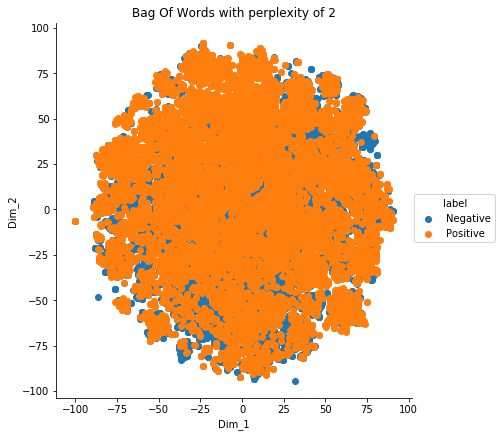

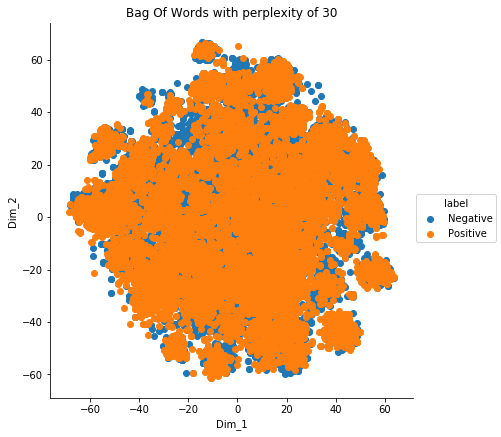

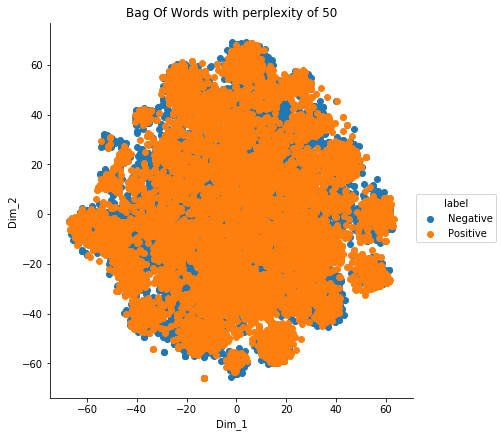

In [20]:
# BoW TSNE

from sklearn.manifold import TSNE
data = bow_counts
labels = clean_data['Score']


svd_bow = TruncatedSVD(n_components=50, random_state=0)
svd_data_bow = svd_bow.fit_transform(data) #reduce dimensions of BoW into 50
scaler = StandardScaler(with_mean=False)
std_bow = scaler.fit_transform(svd_data_bow)

#plot 1
model = TSNE(n_components=2 ,random_state=0 ,perplexity=2)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(std_bow)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Bag Of Words with perplexity of 2")
#plt.show()

#plot 2

model = TSNE(n_components=2 ,random_state=0 ,perplexity=30)

tsne_data = model.fit_transform(std_bow)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Bag Of Words with perplexity of 30")

#plot 3

model = TSNE(n_components=2 ,random_state=0 ,perplexity=50)
tsne_data = model.fit_transform(std_bow)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Bag Of Words with perplexity of 50")
plt.show()



## Observation:
    By seeing all three plots ,there is no big change as the perplexity changes.   


# TF-IDF

In [21]:
#calculate the tf-idf 
tf_idf_vect = TfidfVectorizer()
tfIdf = tf_idf_vect.fit_transform(clean_data['CleanedText'].values)
tfIdf.get_shape()


(20521, 17708)

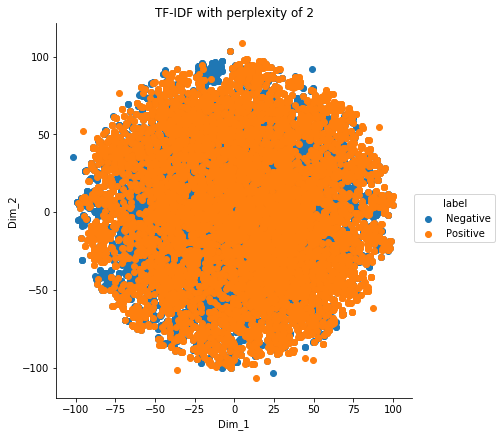

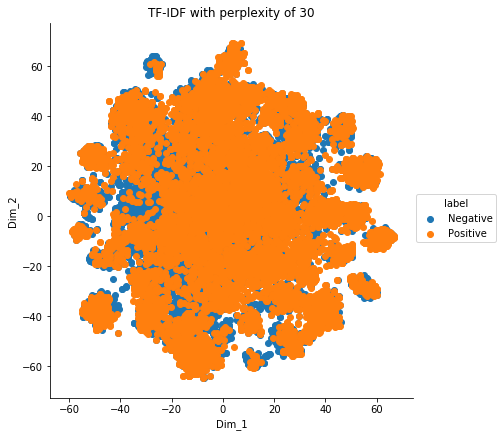

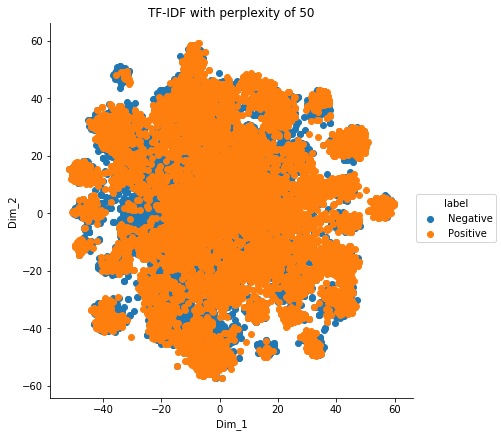

In [22]:
# TF-IDF TSNE

#data = tfIdf.todense()
data = tfIdf
labels = clean_data['Score']


svd_tfidf = TruncatedSVD(n_components=50, random_state=0)
svd_data_tfidf = svd_bow.fit_transform(data) #reduce dimensions of TF-IDF into 50
scaler = StandardScaler(with_mean=False)
std_tfidf = scaler.fit_transform(svd_data_tfidf)

#Plot 1
model = TSNE(n_components=2 ,random_state=0 ,perplexity=2)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(std_tfidf)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TF-IDF with perplexity of 2")


#Plot 2
model = TSNE(n_components=2 ,random_state=0 ,perplexity=30)
tsne_data = model.fit_transform(std_tfidf)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TF-IDF with perplexity of 30")


#Plot 3
model = TSNE(n_components=2 ,random_state=0 ,perplexity=50)
tsne_data = model.fit_transform(std_tfidf)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TF-IDF with perplexity of 50")

plt.show()


## Observation
    By changing the perplexity from 2 to 30 the plots change but it remains moreover same with the increase in perplexity to 50. 

# Avg w2v

In [23]:
#Words to Vector
import gensim
import pickle
i=0
list_of_sentences=[]
for sent in clean_data['CleanedText']:
    filtered_sentence=[]
    for w in sent.split():
        try:
            filtered_sentence.append(w.decode('ASCII'))
        except:
            continue
    list_of_sentences.append(filtered_sentence) 
        
        
#generate w2v vectors from the list of sentences 
w2v=gensim.models.Word2Vec(list_of_sentences,min_count=5,size=50, workers=4)
    
sentence_vectors = [] # the avg-w2v for each sentence/review is stored in this list
count = 0

for sent in list_of_sentences: # for each sentence
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        try:
            vec = w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            count += 1
    if cnt_words!= 0:
        sent_vec /= cnt_words
    sentence_vectors.append(sent_vec)
w2vec = sentence_vectors    

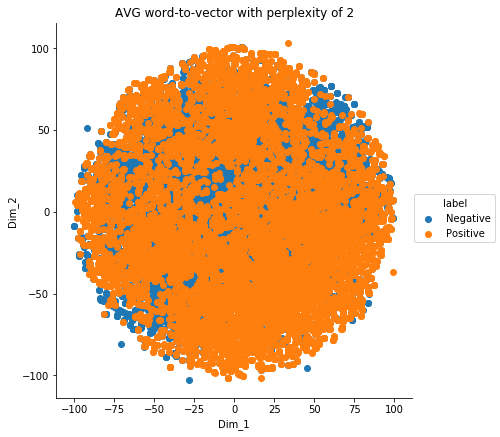

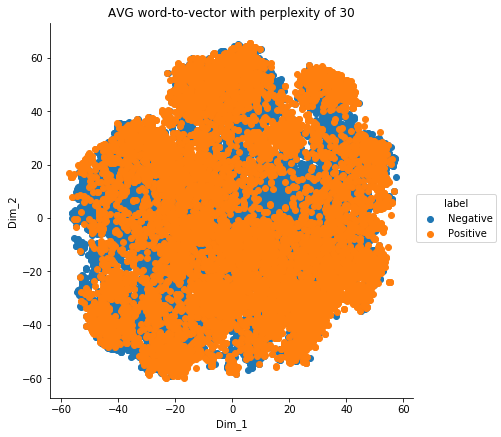

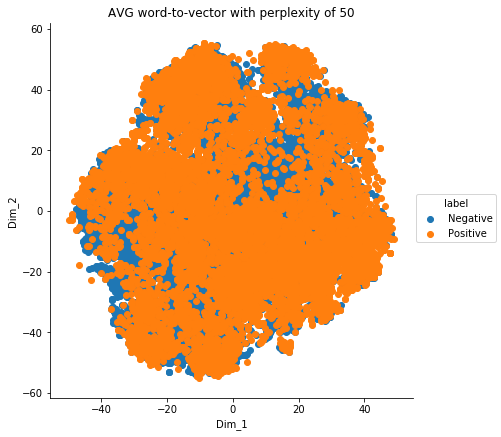

In [31]:
data = w2vec
labels = clean_data['Score']


scaler = StandardScaler(with_mean=False)
std_w2v = scaler.fit_transform(data) 

#Plot 1
model = TSNE(n_components=2, random_state=0 ,perplexity=2)
tsne_data = model.fit_transform(std_w2v)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("AVG word-to-vector with perplexity of 2")


#Plot 2
model = TSNE(n_components=2, random_state=0 ,perplexity=30)
tsne_data = model.fit_transform(std_w2v)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("AVG word-to-vector with perplexity of 30")


#Plot 3
model = TSNE(n_components=2, random_state=0 ,perplexity=50)
tsne_data = model.fit_transform(std_w2v)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("AVG word-to-vector with perplexity of 50")


plt.show()


## Observation
    By changing the perplexity from 2 to 30 the plots change but it remains moreover same with the increase in perplexity to 50. 

# TF-IDF w2v

In [27]:
list_of_sent = w2vec
tfIdf2 = tf_idf_vect

tfidf_feat = tfIdf2.get_feature_names() # tfidf column-names
tfidfw2v = []; # the tfidf-w2v for each sentence in list
row=0;
for sent in list_of_sent: # for each sentence
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence
            tfidf = tfIdf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum!= 0:
            sent_vec /= weight_sum
    tfidfw2v.append(sent_vec)
    row += 1

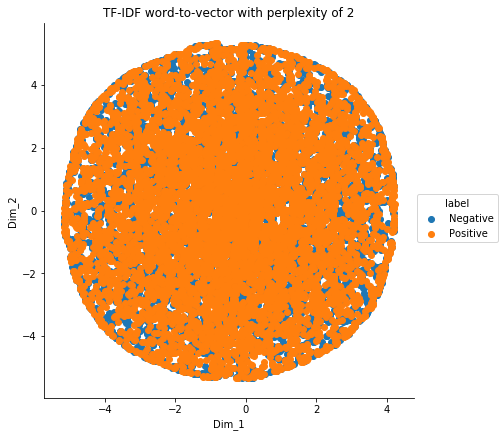

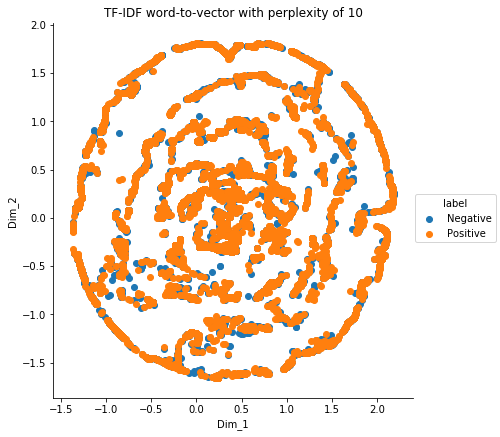

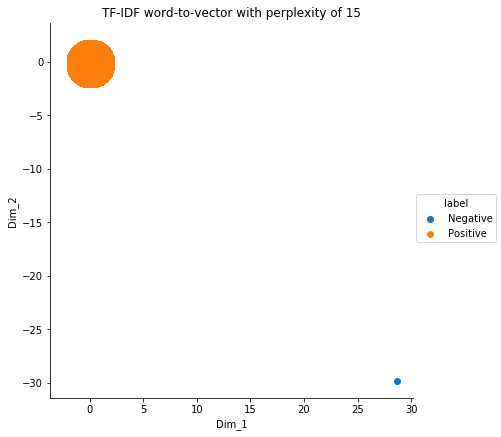

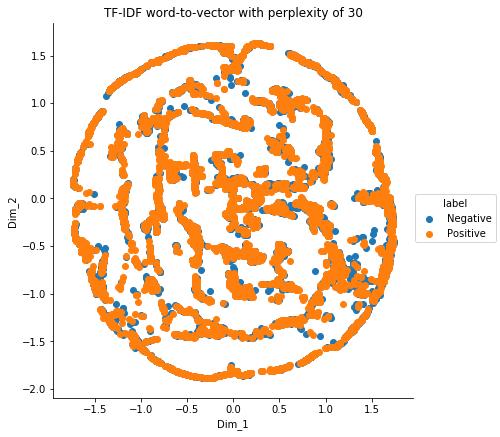

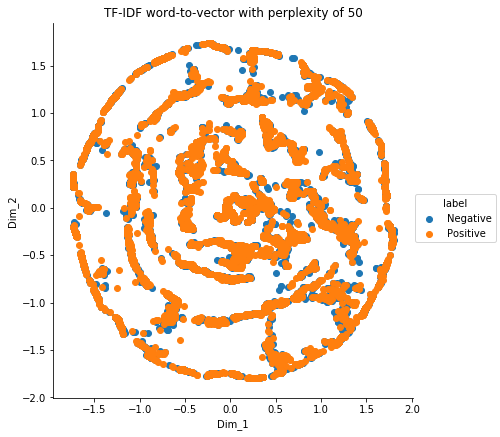

In [30]:
data = tfidfw2v
labels = clean_data['Score']

scaler = StandardScaler(with_mean=False)
std_tfidfw2v = scaler.fit_transform(data)

#Plot 1
model = TSNE(n_components=2, random_state=0 ,perplexity=2)
tsne_data = model.fit_transform(std_tfidfw2v)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TF-IDF word-to-vector with perplexity of 2")

#Plot 2
model = TSNE(n_components=2, random_state=0 ,perplexity=10)
tsne_data = model.fit_transform(std_tfidfw2v)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TF-IDF word-to-vector with perplexity of 10")


#Plot 3
model = TSNE(n_components=2, random_state=0 ,perplexity=15)
tsne_data = model.fit_transform(std_tfidfw2v)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TF-IDF word-to-vector with perplexity of 15")

#Plot 4
model = TSNE(n_components=2, random_state=0 ,perplexity=30)
tsne_data = model.fit_transform(std_tfidfw2v)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TF-IDF word-to-vector with perplexity of 30")


#Plot 5
model = TSNE(n_components=2, random_state=0 ,perplexity=50)
tsne_data = model.fit_transform(std_tfidfw2v)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TF-IDF word-to-vector with perplexity of 50")



plt.show()


## Observation
    By changing the perplexity it can be observed that shape of the plots changes but after some time perplexity doesn't make any change in plot.

# Conclusion
    After seeing all four the plots (Bow ,Tf-idf ,Avg w2v ,Tf-idf w2v ) ,we see that all the positive and negative reviews are overlapping  and hence there is no proper linearly separable and that is obvious because to distinguish a sentence is +ve or -ve there may be small is differences (like as shown in example s1: food is tasty and affordable ,s2:food is not tasty but affordable ,removing the stop words there is just 1 word difference which make it hard to classify b/w these two sentences),a new sentence maybe classified by seeing its neighborhood. Till now we can see that its can't be done using these four technique. 